# Predicting perturbation responses for unseen cell-types (context transfer)

In this tutorial, we will train and evaluate a CPA model on the preprocessed Kang PBMC dataset (See Sup Figures 2-3 [here](https://www.embopress.org/action/downloadSupplement?doi=10.15252%2Fmsb.202211517&file=msb202211517-sup-0001-Appendix.pdf) for a deeper dive).

The following steps are going to be covered:
1. Setting up environment
2. Loading the dataset
3. Preprocessing the dataset
4. Creating a CPA model
5. Training the model
6. Latent space visualisation
7. Prediction evaluation across different perturbations

## Setting up environment

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "latest"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools
    !pip install scanpy
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install git+https://github.com/theislab/cpa
    !pip install scanpy

In [2]:
import os
print("Current directory:", os.getcwd())
os.chdir("../..")
# Verify the new directory
print("New directory:", os.getcwd())
current_dir = os.getcwd()
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Current directory: /Users/jeriel/Documents/WS24:25/MA/cpa/docs/tutorials
New directory: /Users/jeriel/Documents/WS24:25/MA/cpa


In [3]:
import cpa
import scanpy as sc

Global seed set to 0


In [4]:
sc.settings.set_figure_params(dpi=100)

In [5]:
data_path = os.path.join(current_dir, "datasets", "kang_normalized_hvg.h5ad")
print(data_path)

/Users/jeriel/Documents/WS24:25/MA/cpa/datasets/kang_normalized_hvg.h5ad


## Loading dataset

The preprocessed Kang PBMC dataset with `h5ad` extension used for saving/loading anndata objects is publicly available in the [Google Drive](https://drive.google.com/drive/u/0/folders/1yFB0gBr72_KLLp1asojxTgTqgz6cwpju) and can be loaded using the `sc.read` function with the `backup_url` argument. The datasets is normalized & pre-processed using `scanpy`. Top 5000 highly variable genes are selected. 

In [6]:
try:
    adata = sc.read(data_path)
except:
    import gdown
    gdown.download('https://drive.google.com/uc?export=download&id=1z8gGKQ6oDoi2blCU2IVihKA38h5fORRp')
    data_path = data_path
    adata = sc.read(data_path)

adata

AnnData object with n_obs × n_vars = 13576 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'cov_cond', 'split_CD14 Mono', 'split_CD4 T', 'split_T', 'split_CD8 T', 'split_B', 'split_DC', 'split_CD16 Mono', 'split_NK'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol'
    uns: 'hvg', 'log1p', 'rank_genes_groups_cov'
    layers: 'counts'

Next, we just replace `adata.X` with raw counts to be able to train CPA with Negative Binomial (NB) or Zero-Inflated Negative Binomial (ZINB) loss.

In [7]:
adata.X = adata.layers['counts'].copy()

## Dataset setup
Now is the time to setup the dataset for CPA to prepare the dataset for training. Just like scvi-tools models, you can call `cpa.CPA.setup_anndata` to setup your data. This function will accept the following arguments:

- `adata`: AnnData object containing the data to be preprocessed
- `perturbation_key`: The key in `adata.obs` that contains the perturbation information
- `control_group`: The name of the control group in `perturbation_key`
- `batch_key`: The key in `adata.obs` that contains the batch information
- `dosage_key`: The key in `adata.obs` that contains the dosage information
- `categorical_covariate_keys`: A list of keys in `adata.obs` that contain categorical covariates
- `is_count_data`: Whether the `adata.X` is count data or not
- `deg_uns_key`: The key in `adata.uns` that contains the differential expression results
- `deg_uns_cat_key`: The key in `adata.obs` that contains the category information of each cell which can be used as to access differential expression results in `adata.uns[deg_uns_key]`. For example, if `deg_uns_key` is `rank_genes_groups_cov` and `deg_uns_cat_key` is `cov_cond`, then `adata.uns[deg_uns_key][cov_cond]` will contain the differential expression results for each category in `cov_cond`.
- `max_comb_len`: The maximum number of perturbations that are applied to each cell. For example, if `max_comb_len` is 2, then the model will be trained to predict the effect of single perturbations and the effect of double perturbations.

We will create a dummy dosage variable for each condition (control, IFN-beta stimulated). It is recommended to use Identity (i.e. doser_type = 'identity') for dosage scaling function when there is no dosage information available.

In [8]:
adata.obs['dose'] = adata.obs['condition'].apply(lambda x: '+'.join(['1.0' for _ in x.split('+')]))

In [9]:
adata.obs['cell_type'].value_counts()

cell_type
CD14 Mono    4362
CD4 T        4266
B            1366
CD16 Mono    1044
CD8 T         814
T             633
NK            619
DC            472
Name: count, dtype: int64

In [10]:
adata.obs['condition'].value_counts()

condition
stimulated    7217
ctrl          6359
Name: count, dtype: int64

In [11]:
cpa.CPA.setup_anndata(adata, 
                      perturbation_key='condition',
                      control_group='ctrl',
                      dosage_key='dose',
                      categorical_covariate_keys=['cell_type'],
                      is_count_data=True,
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_cond',
                      max_comb_len=1,
                     )

100%|██████████| 16/16 [00:00<00:00, 2327.58it/s]


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [17]:
model_params = {
    "n_latent": 64,
    "recon_loss": "nb",
    "doser_type": "linear",
    "n_hidden_encoder": 128,
    "n_layers_encoder": 2,
    "n_hidden_decoder": 512,
    "n_layers_decoder": 2,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": False,
    "use_layer_norm_decoder": True,
    "dropout_rate_encoder": 0.0,
    "dropout_rate_decoder": 0.1,
    "variational": False,
    "seed": 6977,
    "use_intense": True
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 0,
    "mixup_alpha": 0.0,
    "adv_steps": None,
    "n_hidden_adv": 64,
    "n_layers_adv": 3,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 5.0,
    "lr": 0.0003,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": True,
    "gradient_clip_value": 1.0,
    "step_size_lr": 10,
}

## CPA Model

You can create a CPA model by creating an object from `cpa.CPA` class. The constructor of this class takes the following arguments:
**Data related parameters:** 
- `adata`: AnnData object containing train/valid/test data
- `split_key`: The key in `adata.obs` that contains the split information
- `train_split`: The value in `split_key` that corresponds to the training data
- `valid_split`: The value in `split_key` that corresponds to the validation data
- `test_split`: The value in `split_key` that corresponds to the test data
**Model architecture parameters:**
- `n_latent`: Number of latent dimensions
- `recon_loss`: Reconstruction loss function. Currently, Supported losses are `nb`, `zinb`, and `gauss`.
- `n_hidden_encoder`: Number of hidden units in the encoder
- `n_layers_encoder`: Number of layers in the encoder
- `n_hidden_decoder`: Number of hidden units in the decoder
- `n_layers_decoder`: Number of layers in the decoder
- `use_batch_norm_encoder`: Whether to use batch normalization in the encoder
- `use_layer_norm_encoder`: Whether to use layer normalization in the encoder
- `use_batch_norm_decoder`: Whether to use batch normalization in the decoder
- `use_layer_norm_decoder`: Whether to use layer normalization in the decoder
- `dropout_rate_encoder`: Dropout rate in the encoder
- `dropout_rate_decoder`: Dropout rate in the decoder
- `variational`: Whether to use variational inference. NOTE: False is highly recommended.
- `seed`: Random seed

In this notebook, we left out `B` cells treated with  `IFN-beta` from the training dataset (OOD set) and randomly split the remaining cells into train/valid sets. The split information is stored in `adata.obs['split_B']` column. We would like to see if the model can predict how `B` cells can respond to `IFN-beta` stimulation.

In [18]:
model = cpa.CPA(adata=adata, 
                split_key='split_B',
                train_split='train',
                valid_split='valid',
                test_split='ood',
                **model_params,
               )

Global seed set to 6977


## Training CPA

In order to train your CPA model, you need to use `train` function of your `model`. This function accepts the following parameters:
- `max_epochs`: Maximum number of epochs to train the model. CPA generally converges after high number of epochs, so you can set this to a high value.
- `use_gpu`: If you have a GPU, you can set this to `True` to speed up the training process.
- `batch_size`: Batch size for training. You can set this to a high value (e.g. 512, 1024, 2048) if you have a GPU. 
- `plan_kwargs`: dictionary of parameters passed the CPA's `TrainingPlan`. You can set the following parameters:
    * `n_epochs_adv_warmup`: Number of epochs to linearly increase the weight of adversarial loss. 
    * `n_epochs_mixup_warmup`: Number of epochs to linearly increase the weight of mixup loss.
    * `n_epochs_pretrain_ae`: Number of epochs to pretrain the autoencoder.
    * `lr`: Learning rate for training autoencoder.
    * `wd`: Weight decay for training autoencoder.
    * `adv_lr`: Learning rate for training adversary.
    * `adv_wd`: Weight decay for training adversary.
    * `adv_steps`: Number of steps to train adversary for each step of autoencoder.
    * `reg_adv`: Maximum Weight of adversarial loss.
    * `pen_adv`: Penalty weight of adversarial loss.
    * `n_layers_adv`: Number of layers in adversary.
    * `n_hidden_adv`: Number of hidden units in adversary.
    * `use_batch_norm_adv`: Whether to use batch normalization in adversary.
    * `use_layer_norm_adv`: Whether to use layer normalization in adversary.
    * `dropout_rate_adv`: Dropout rate in adversary.
    * `step_size_lr`: Step size for learning rate scheduler.
    * `do_clip_grad`: Whether to clip gradients by norm.
    * `clip_grad_value`: Maximum value of gradient norm.
    * `adv_loss`: Type of adversarial loss. Can be either `cce` for Cross Entropy loss or `focal` for Focal loss.
    * `n_epochs_verbose`: Number of epochs to print latent information disentanglement evaluation.
- `early_stopping_patience`: Number of epochs to wait before stopping training if validation metric does not improve.
- `check_val_every_n_epoch`: Number of epochs to wait before running validation.
- `save_path`: Path to save the best model after training.



In [20]:
model.train(max_epochs=2000,
            use_gpu=False, 
            batch_size=512,
            plan_kwargs=trainer_params,
            early_stopping_patience=5,
            check_val_every_n_epoch=5,
            save_path= os.path.join(current_dir,'lightning_logs','Kang' )
           )


100%|██████████| 2/2 [00:00<00:00, 85.59it/s]
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 1/2000:   0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
cpa.pl.plot_history(model)

## Restore best model

In case you have already saved your pretrained model, you can restore it using the following code. The `cpa.CPA.load` function accepts the following arguments:
- `dir_path`: path to the directory where the model is saved
- `adata`: anndata object
- `use_gpu`: whether to use GPU or not


INFO     File /Users/jeriel/Documents/WS24:25/MA/cpa/lightning_logs/Kang_Intense_SGD_Optimized/model.pt already    
         downloaded                                                                                                


100%|██████████| 16/16 [00:00<00:00, 450.95it/s]
Global seed set to 6484


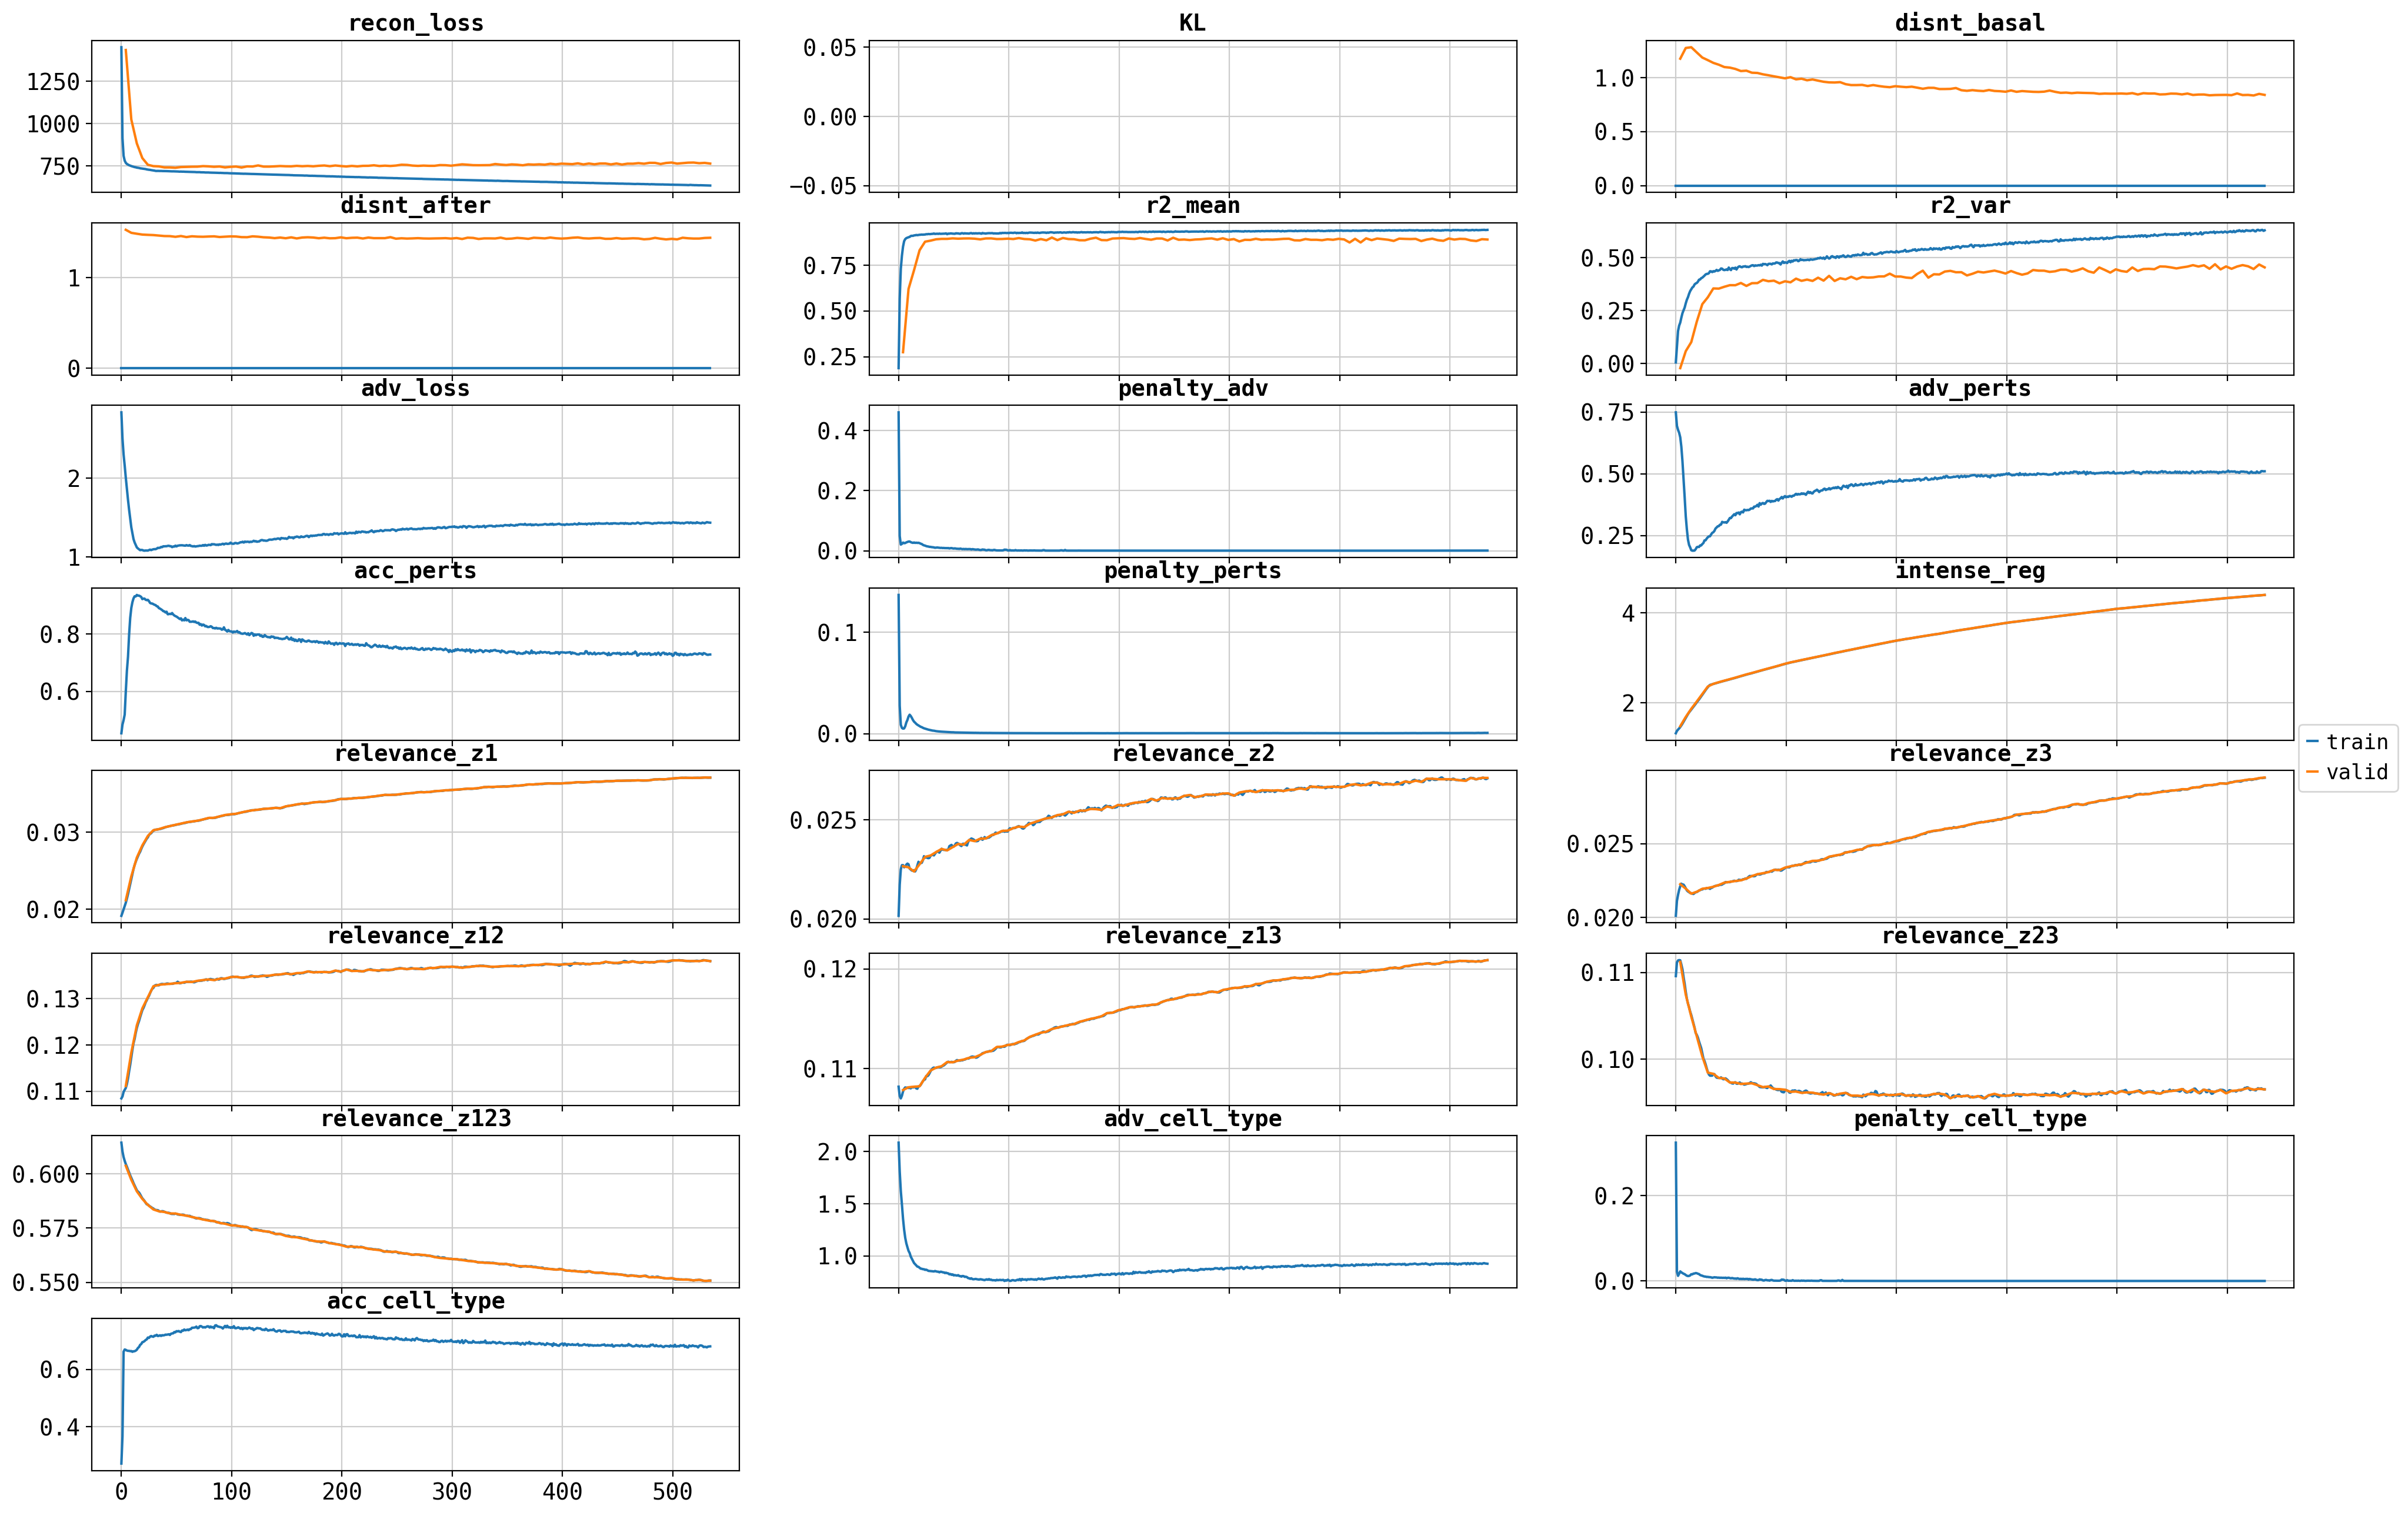

In [23]:
model = cpa.CPA.load(dir_path= current_dir +'/lightning_logs/Kang_Intense_SGD_Optimized/',
                      adata=adata,
                      use_gpu=False)
cpa.pl.plot_history(model)

## Latent Space Visualization

latent vectors of all cells can be computed with `get_latent_representation` function. This function produces a python dictionary with the following keys:
- `latent_basal`: latent vectors of all cells in basal state of autoencoder
- `latent_after`: final latent vectors which can be used for decoding
- `latent_corrected`: batch-corrected latents if batch_key was provided

In [24]:
latent_outputs = model.get_latent_representation(adata, batch_size=2048)

100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


In [25]:
latent_outputs.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

In [26]:
sc.pp.neighbors(latent_outputs['latent_basal'])
sc.tl.umap(latent_outputs['latent_basal'])

As observed below, the basal representation should be free of the variation(s) of the `condition` and `cell_type`. 

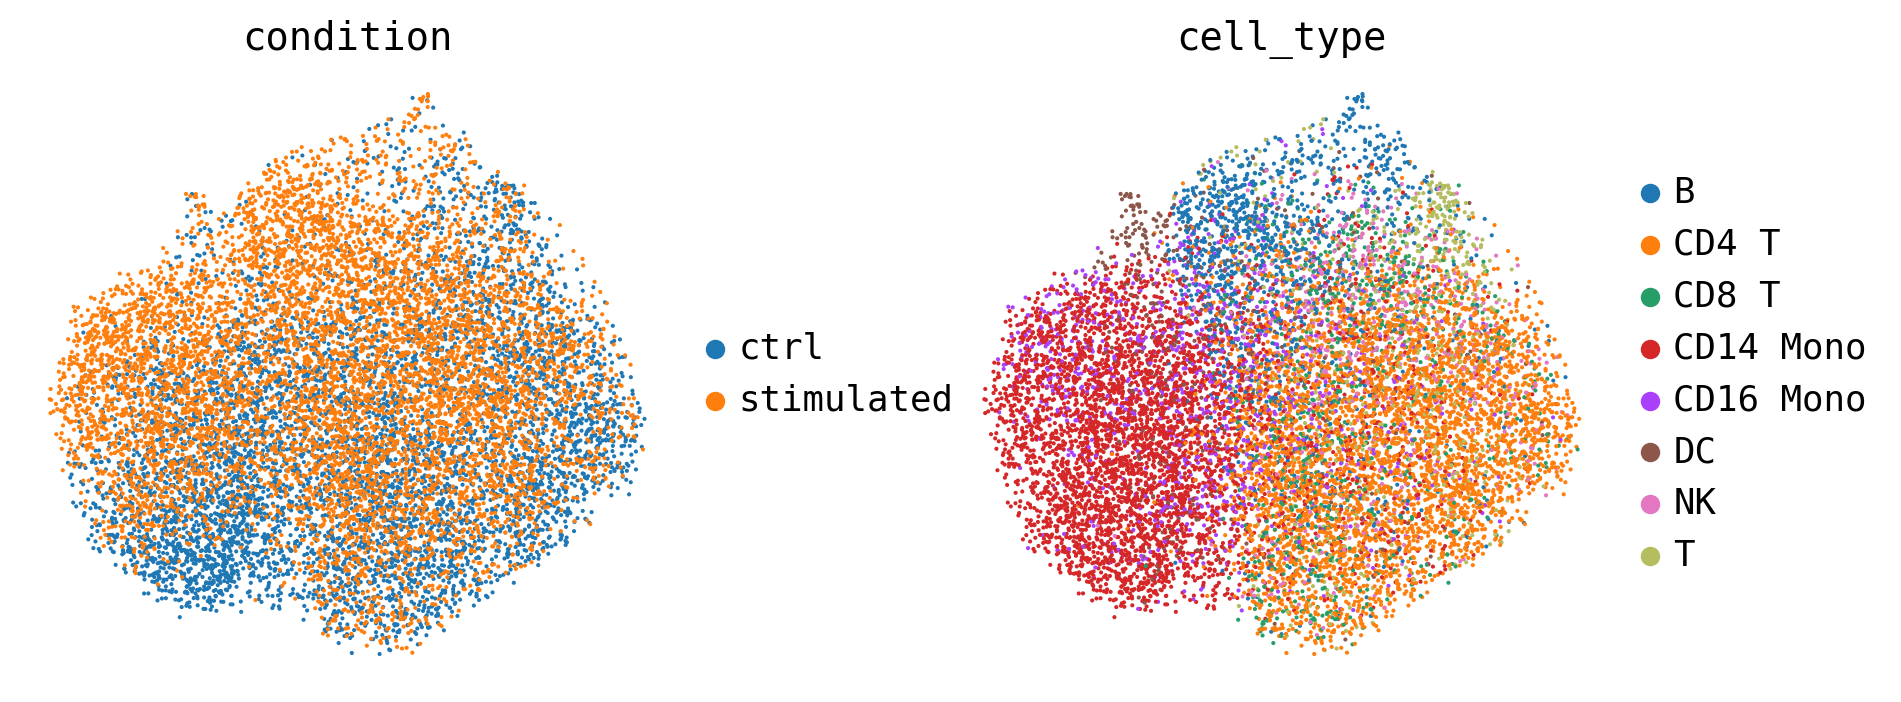

In [27]:
sc.pl.umap(latent_outputs['latent_basal'], 
           color=['condition', 'cell_type'],
           frameon=False, 
           wspace=0.3)

In [28]:
sc.pp.neighbors(latent_outputs['latent_after'])
sc.tl.umap(latent_outputs['latent_after'])

Here, you can visualize that when the `condition` and `cell_type` embeddings are added to the basal representation,
As you can see now cell types and conditions are separated. 

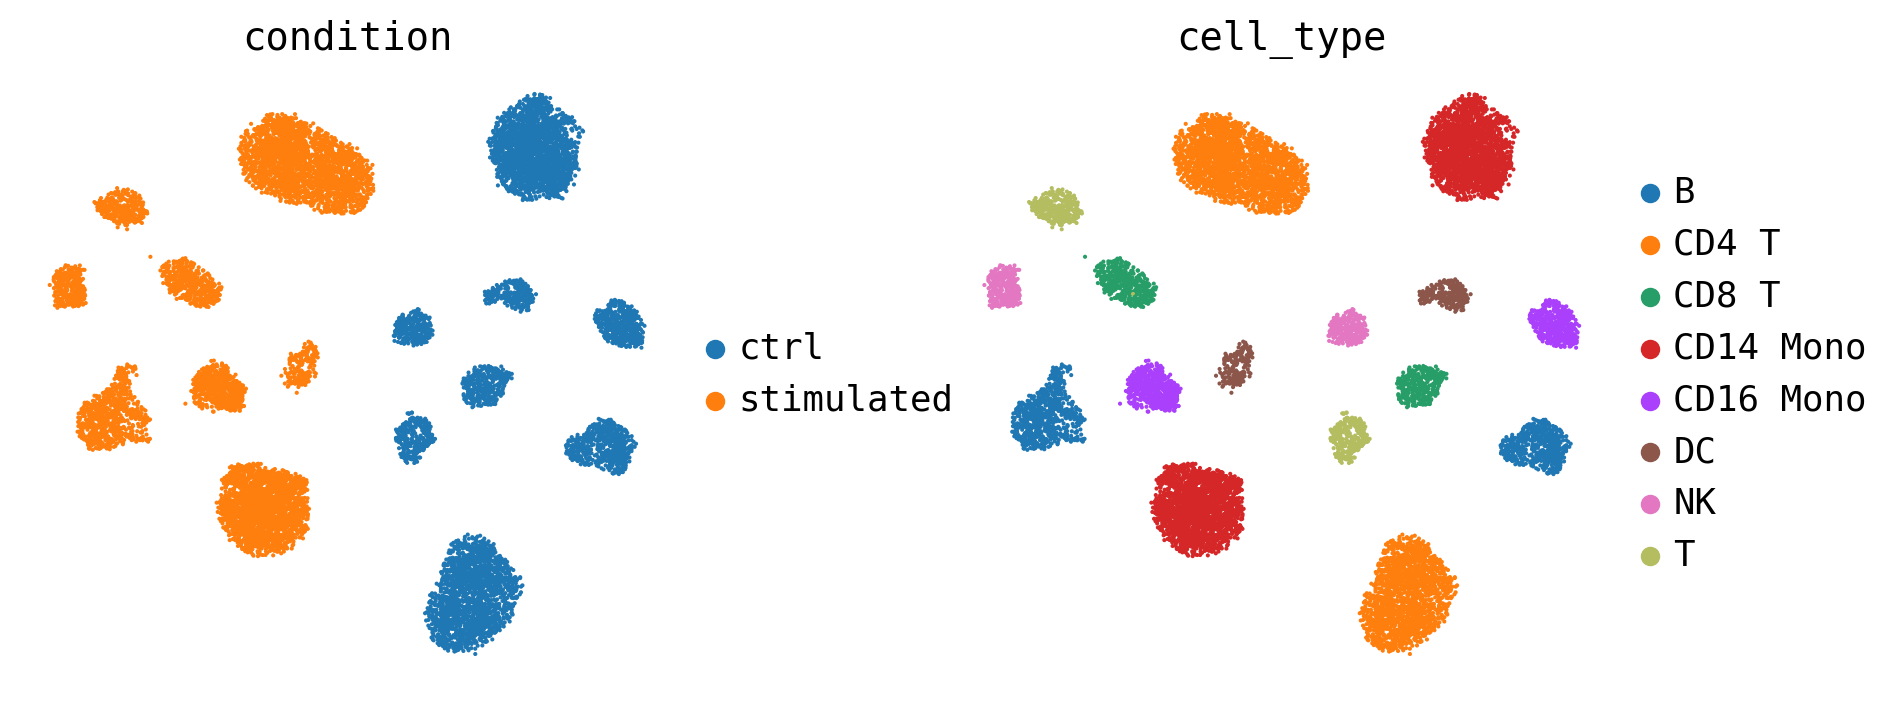

In [29]:
sc.pl.umap(latent_outputs['latent_after'], 
           color=['condition', 'cell_type'], 
           frameon=False,
           wspace=0.3)

## Evaluation


To evaluate the model's prediction performance, we can use `model.predict()` function. $R^2$ score for each combination of `<cell_type, stimulated>` is computed over mean statistics of the top 50, 20, and 10 DEGs (including all genes). CPA transfers the context from control to IFN-beta stimulated for each cell type. Next, we will evaluate the model's prediction performance on the whole dataset, including OOD (test) cells. The model will report metrics on how well we have
captured the variation in top `n` differentially expressed genes when compared to control cells
(`CTRL`)  for each condition. The metrics calculate the mean accuracy (`r2_mean_deg`), the variance (`r2_var_deg`) and similar metrics (`r2_mean_lfc_deg` and `log fold change`)to measure the log fold change of the predicted cells vs control`((LFC(control, ground truth) ~ LFC(control, predicted cells))`.  The `R2` is the `sklearn.metrics.r2_score` from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).

In [30]:
model.predict(adata, batch_size=2048)

100%|██████████| 7/7 [00:05<00:00,  1.37it/s]


In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from collections import defaultdict
from tqdm import tqdm

n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)
for cat in tqdm(adata.obs['cov_cond'].unique()):
    if 'ctrl' not in cat:
        cov, condition = cat.split('_')
        cat_adata = adata[adata.obs['cov_cond'] == cat].copy()
        ctrl_adata = adata[adata.obs['cov_cond'] == f'{cov}_ctrl'].copy()

        deg_cat = f'{cat}'
        deg_list = adata.uns['rank_genes_groups_cov'][deg_cat]
        
        x_true = cat_adata.layers['counts']
        x_pred = cat_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts']

        x_true = np.log1p(x_true)
        x_pred = np.log1p(x_pred)
        x_ctrl = np.log1p(x_ctrl)

        for n_top_deg in n_top_degs:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
                
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]
            
            r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))
            r2_var_deg = r2_score(x_true_deg.var(0), x_pred_deg.var(0))

            r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
            r2_var_lfc_deg = r2_score(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))
            
            results['condition'].append(condition)
            results['cell_type'].append(cov)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_var_deg'].append(r2_var_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)
            results['r2_var_lfc_deg'].append(r2_var_lfc_deg)

df = pd.DataFrame(results)

100%|██████████| 16/16 [00:03<00:00,  4.85it/s]


In [32]:
df

,condition,cell_type,n_top_deg,r2_mean_deg,r2_var_deg,r2_mean_lfc_deg,r2_var_lfc_deg
0,stimulated,CD8 T,10,0.953305,-4.824300,0.931042,-3.222894
1,stimulated,CD8 T,20,0.953342,-3.239874,0.933841,-2.599710
2,stimulated,CD8 T,50,0.959514,0.043279,0.943214,-1.310941
3,stimulated,CD8 T,all,0.962680,0.650323,0.879960,-0.781550
4,stimulated,CD4 T,10,0.958380,-52.896950,0.942449,-2.736399
5,stimulated,CD4 T,20,0.948194,-8.193960,0.927011,-2.898428
6,stimulated,CD4 T,50,0.963004,-0.171734,0.951480,-1.750942
7,stimulated,CD4 T,all,0.960149,0.492197,0.884759,-1.409133
8,stimulated,B,10,0.378069,-0.821373,-0.013974,-0.378542
9,stimulated,B,20,0.506399,-1.060546,0.344749,-0.605261
